In [1]:
# Cell 1: Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Cell 2: Load and explore dataset
print("Loading Newsgroups dataset...")
categories = ['comp.graphics', 'rec.autos', 'rec.motorcycles',
              'sci.crypt', 'sci.electronics', 'sci.space']

newsgroups = fetch_20newsgroups(
    subset='all',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

print(f"\nDataset Information:")
print(f"Number of documents: {len(newsgroups.data)}")
print(f"Number of classes: {len(newsgroups.target_names)}")
print(f"\nClass Names:")
for i, name in enumerate(newsgroups.target_names):
    print(f"{i}: {name}")

Loading Newsgroups dataset...

Dataset Information:
Number of documents: 5921
Number of classes: 6

Class Names:
0: comp.graphics
1: rec.autos
2: rec.motorcycles
3: sci.crypt
4: sci.electronics
5: sci.space


In [5]:
# Cell 3: Create train-test split for traditional ML models
X_train, X_test, y_train, y_test = train_test_split(
    newsgroups.data,
    newsgroups.target,
    test_size=0.2,
    random_state=42,
    stratify=newsgroups.target
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Classes distribution in training: {np.bincount(y_train)}")

Training samples: 4736
Test samples: 1185
Classes distribution in training: [778 792 797 793 787 789]


In [6]:
# Cell 4: TF-IDF Vectorization
print("Transforming text data to TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

Transforming text data to TF-IDF features...
TF-IDF feature matrix shape: (4736, 5000)
Vocabulary size: 5000


In [7]:
# Cell 5: Feature selection using Chi-squared
print("Performing feature selection using Chi-squared test...")
k_best = 1000
chi2_selector = SelectKBest(chi2, k=k_best)
X_train_final = chi2_selector.fit_transform(X_train_tfidf, y_train)
X_test_final = chi2_selector.transform(X_test_tfidf)
print(f"Selected {k_best} best features")

Performing feature selection using Chi-squared test...
Selected 1000 best features


In [8]:
# Cell 6: Setup cross-validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Cell 7: SVM Model with GridSearchCV
print("\n" + "="*60)
print("SUPPORT VECTOR MACHINE (SVM)")
print("="*60)

svm_model = SVC(kernel='linear', random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

print("Performing hyperparameter tuning for SVM...")
start_time = time.time()
grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    cv=cv_stratified,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
grid_search_svm.fit(X_train_final, y_train)
svm_training_time = time.time() - start_time

print(f"\nSVM Training completed in {svm_training_time:.2f} seconds")
print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best CV score: {grid_search_svm.best_score_:.4f}")


SUPPORT VECTOR MACHINE (SVM)
Performing hyperparameter tuning for SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

SVM Training completed in 49.75 seconds
Best parameters: {'C': 1, 'class_weight': 'balanced'}
Best CV score: 0.7865


In [10]:
# Cell 8: Evaluate SVM
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_final)

# Calculate metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("\nSVM Performance Metrics:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1-Score: {svm_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=newsgroups.target_names))


SVM Performance Metrics:
Accuracy: 0.7848
Precision: 0.8097
Recall: 0.7848
F1-Score: 0.7899

Detailed Classification Report:
                 precision    recall  f1-score   support

  comp.graphics       0.89      0.78      0.84       195
      rec.autos       0.82      0.74      0.78       198
rec.motorcycles       0.62      0.86      0.72       199
      sci.crypt       0.94      0.77      0.85       198
sci.electronics       0.67      0.77      0.72       197
      sci.space       0.91      0.78      0.84       198

       accuracy                           0.78      1185
      macro avg       0.81      0.78      0.79      1185
   weighted avg       0.81      0.78      0.79      1185



In [11]:
# Cell 9: Random Forest Model with GridSearchCV
print("\n" + "="*60)
print("RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 50, 100],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

print("Performing hyperparameter tuning for Random Forest...")
start_time = time.time()
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=cv_stratified,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train_final, y_train)
rf_training_time = time.time() - start_time

print(f"\nRandom Forest Training completed in {rf_training_time:.2f} seconds")
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best CV score: {grid_search_rf.best_score_:.4f}")


RANDOM FOREST
Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Random Forest Training completed in 681.07 seconds
Best parameters: {'class_weight': None, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.7786


In [12]:
# Cell 10: Evaluate Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_final)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("\nRandom Forest Performance Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")

# Feature importance
feature_names = np.array(tfidf.get_feature_names_out())
selected_feature_indices = chi2_selector.get_support(indices=True)
selected_feature_names = feature_names[selected_feature_indices]
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:]

print("\nTop 10 Most Important Features:")
for i in indices[-10:][::-1]:
    print(f"{selected_feature_names[i]}: {importances[i]:.4f}")


Random Forest Performance Metrics:
Accuracy: 0.7755
Precision: 0.8013
Recall: 0.7755
F1-Score: 0.7810

Top 10 Most Important Features:
car: 0.0291
bike: 0.0242
space: 0.0204
graphics: 0.0166
cars: 0.0156
clipper: 0.0142
dod: 0.0109
encryption: 0.0104
government: 0.0101
key: 0.0099



TRADITIONAL ML MODELS COMPARISON

Model Performance Comparison:
        Model  Accuracy  Precision   Recall  F1-Score  Training Time (s)
          SVM  0.784810   0.809718 0.784810  0.789916          49.753923
Random Forest  0.775527   0.801314 0.775527  0.781039         681.065393

SVM CV Accuracy: 0.7794 (+/- 0.0168)
Random Forest CV Accuracy: 0.7745 (+/- 0.0265)


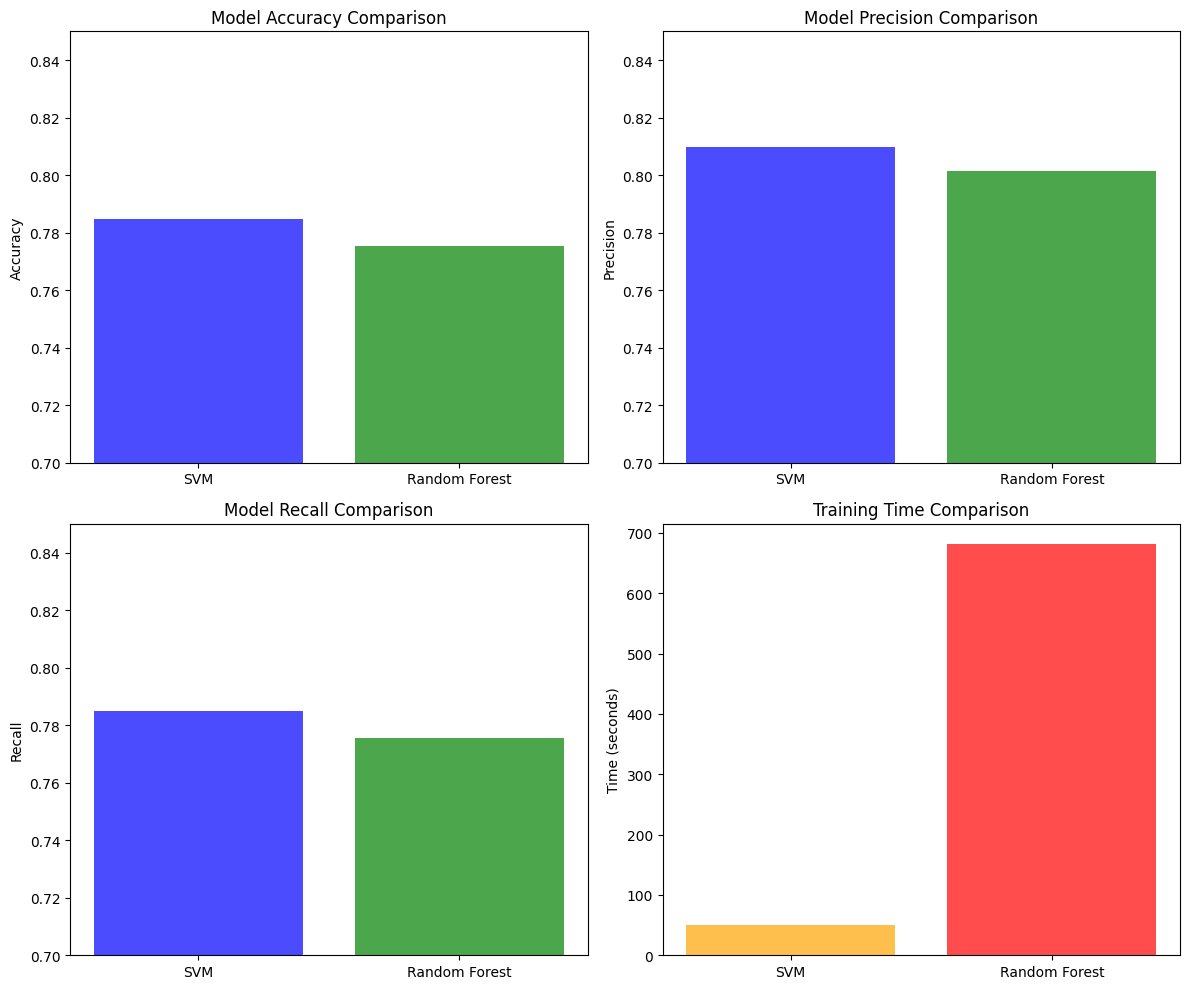

In [26]:
# Cell 11: Traditional ML Models Comparison
print("\n" + "="*60)
print("TRADITIONAL ML MODELS COMPARISON")
print("="*60)

comparison_data = {
    'Model': ['SVM', 'Random Forest'],
    'Accuracy': [svm_accuracy, rf_accuracy],
    'Precision': [svm_precision, rf_precision],
    'Recall': [svm_recall, rf_recall],
    'F1-Score': [svm_f1, rf_f1],
    'Training Time (s)': [svm_training_time, rf_training_time]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Cross-validation comparison
cv_scores_svm = cross_val_score(best_svm, X_train_final, y_train,
                               cv=cv_stratified, scoring='accuracy', n_jobs=-1)
cv_scores_rf = cross_val_score(best_rf, X_train_final, y_train,
                              cv=cv_stratified, scoring='accuracy', n_jobs=-1)

print(f"\nSVM CV Accuracy: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")
print(f"Random Forest CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Visualization
fig, axes = plt.subplots(2, 2,figsize=(12, 10))

# Accuracy Comparison
axes[0, 0].bar(['SVM', 'Random Forest'], [svm_accuracy, rf_accuracy],
            color=['blue', 'green'], alpha=0.7)
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0.7, 0.85])

# Precision Comparison
axes[0, 1].bar(['SVM', 'Random Forest'], [svm_precision, rf_precision],
            color=['blue', 'green'], alpha=0.7)
axes[0, 1].set_title('Model Precision Comparison')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0.7, 0.85])

# Recall Comparison
axes[1, 0].bar(['SVM', 'Random Forest'], [svm_recall, rf_recall],
            color=['blue', 'green'], alpha=0.7)
axes[1, 0].set_title('Model Recall Comparison')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim([0.7, 0.85])

# Training Time Comparison
axes[1, 1].bar(['SVM', 'Random Forest'], [svm_training_time, rf_training_time],
            color=['orange', 'red'], alpha=0.7)
axes[1, 1].set_title('Training Time Comparison')
axes[1, 1].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [14]:
# Cell 12: Neural Network - Data Preparation
print("\n" + "="*60)
print("DENSE NEURAL NETWORK")
print("="*60)

# Tokenization
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 500

print("\nTokenizing text data for neural network...")
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH,
                               padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH,
                              padding='post', truncating='post')

y_train_categorical = to_categorical(y_train, num_classes=len(categories))
y_test_categorical = to_categorical(y_test, num_classes=len(categories))

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train_padded.shape}")
print(f"Test data shape: {X_test_padded.shape}")


DENSE NEURAL NETWORK

Tokenizing text data for neural network...
Vocabulary size: 40471
Training data shape: (4736, 500)
Test data shape: (1185, 500)


In [15]:
# Cell 13: Create Neural Network Model
def create_dense_model(embedding_dim=128, vocab_size=MAX_VOCAB_SIZE,
                       sequence_length=MAX_SEQUENCE_LENGTH, num_classes=6):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                 input_length=sequence_length, name="embedding"),
        GlobalAveragePooling1D(name="global_avg_pool"),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001), name="dense_1"),
        BatchNormalization(name="batch_norm_1"),
        Dropout(0.5, name="dropout_1"),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001), name="dense_2"),
        BatchNormalization(name="batch_norm_2"),
        Dropout(0.4, name="dropout_2"),
        Dense(64, activation='relu', name="dense_3"),
        Dropout(0.3, name="dropout_3"),
        Dense(num_classes, activation='softmax', name="output")
    ])
    return model

dense_model = create_dense_model()
dense_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Cell 14: Compile and Setup Callbacks
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
dense_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001,
                  verbose=1, restore_best_weights=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                     min_lr=1e-6, verbose=1, mode='min')
]

# Validation split
X_train_final_nn, X_val, y_train_final_nn, y_val = train_test_split(
    X_train_padded, y_train_categorical,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

print(f"Final training samples: {X_train_final_nn.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test_padded.shape[0]}")

Final training samples: 4262
Validation samples: 474
Test samples: 1185


In [34]:
# Cell 15: Train Neural Network
start_time_nn = time.time()
print("\nTraining Dense Neural Network...")
history = dense_model.fit(
    X_train_final_nn, y_train_final_nn,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)
nn_training_time = time.time() - start_time_nn
print(f"\nNeural Network training completed in {nn_training_time:.2f} seconds")


Training Dense Neural Network...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8909 - loss: 0.5571 - precision: 0.9566 - recall: 0.8345 - val_accuracy: 0.6920 - val_loss: 0.9661 - val_precision: 0.8260 - val_recall: 0.6308 - learning_rate: 6.2500e-05
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9025 - loss: 0.5254 - precision: 0.9677 - recall: 0.8543 - val_accuracy: 0.7342 - val_loss: 0.9221 - val_precision: 0.8198 - val_recall: 0.6624 - learning_rate: 6.2500e-05
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9079 - loss: 0.5082 - precision: 0.9660 - recall: 0.8580 - val_accuracy: 0.7511 - val_loss: 0.8815 - val_precision: 0.8198 - val_recall: 0.7004 - learning_rate: 6.2500e-05
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9154 - loss: 0.4858 - precision: 0.9775 - recall: 0.8676 - val_accuracy: 0.7321 - val_loss: 0.9519 - val_precision: 0.7764 - val_recall: 0.6814 - learning_rate: 6.2500e-05
Epoch 5/50
67/67 ━

In [35]:
# Cell 16: Evaluate Neural Network
y_pred_proba = dense_model.predict(X_test_padded, verbose=0)
y_pred_nn = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

nn_accuracy = accuracy_score(y_true, y_pred_nn)
nn_precision = precision_score(y_true, y_pred_nn, average='weighted')
nn_recall = recall_score(y_true, y_pred_nn, average='weighted')
nn_f1 = f1_score(y_true, y_pred_nn, average='weighted')

print(f"\nNeural Network Performance:")
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")
print(f"F1-Score: {nn_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred_nn, target_names=categories))


Neural Network Performance:
Accuracy: 0.8025
Precision: 0.8198
Recall: 0.8025
F1-Score: 0.8036

Detailed Classification Report:
                 precision    recall  f1-score   support

  comp.graphics       0.85      0.85      0.85       195
      rec.autos       0.81      0.74      0.77       198
rec.motorcycles       0.91      0.74      0.82       199
      sci.crypt       0.81      0.88      0.84       198
sci.electronics       0.90      0.70      0.79       197
      sci.space       0.65      0.90      0.75       198

       accuracy                           0.80      1185
      macro avg       0.82      0.80      0.80      1185
   weighted avg       0.82      0.80      0.80      1185



In [36]:
# Cell 17: Analyze Learned Embeddings
print("\n" + "="*60)
print("ANALYZING LEARNED EMBEDDINGS")
print("="*60)

# Get the embedding layer weights
embedding_layer = dense_model.get_layer('embedding')
embedding_weights = embedding_layer.get_weights()[0]

print(f"Embedding matrix shape: {embedding_weights.shape}")
print(f"Each word is represented as a {embedding_weights.shape[1]}-dimensional vector")

# Find similar words using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_words(word, tokenizer, embedding_weights, top_n=5):
    if word not in tokenizer.word_index:
        print(f"Word '{word}' not in vocabulary")
        return

    word_idx = tokenizer.word_index[word]
    if word_idx >= MAX_VOCAB_SIZE:
        print(f"Word '{word}' is beyond vocabulary limit")
        return

    word_vector = embedding_weights[word_idx].reshape(1, -1)
    similarities = cosine_similarity(word_vector, embedding_weights)
    similar_indices = similarities[0].argsort()[::-1][1:top_n+1]

    print(f"\nWords similar to '{word}':")
    for idx in similar_indices:
        for w, i in tokenizer.word_index.items():
            if i == idx and i < MAX_VOCAB_SIZE:
                similarity = similarities[0][idx]
                print(f"  {w}: {similarity:.4f}")
                break

# Test with some words
test_words = ['computer', 'car', 'motorcycle', 'encryption', 'space', 'electronics']
for word in test_words:
    find_similar_words(word, tokenizer, embedding_weights)


ANALYZING LEARNED EMBEDDINGS
Embedding matrix shape: (10000, 128)
Each word is represented as a 128-dimensional vector

Words similar to 'computer':
  3d: 0.7717
  graphics: 0.7607
  rs6000: 0.7317
  adobe: 0.7307
  write: 0.7175

Words similar to 'car':
  cars: 0.9218
  auto: 0.8786
  toyota: 0.8675
  ford: 0.8625
  dealer: 0.8355

Words similar to 'motorcycle':
  bike: 0.9077
  bikes: 0.8873
  ride: 0.8780
  dod: 0.8742
  motorcycles: 0.8742

Words similar to 'encryption':
  clipper: 0.8712
  trust: 0.8699
  nsa: 0.8643
  encrypted: 0.8635
  crypto: 0.8460

Words similar to 'space':
  shuttle: 0.8755
  moon: 0.8692
  launch: 0.8687
  sky: 0.8673
  allen: 0.8668

Words similar to 'electronics':
  circuit: 0.8283
  tape: 0.8009
  rf: 0.7974
  led: 0.7854
  intel: 0.7788


In [37]:
# Cell 18: Final Comparison & Recommendation
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

final_comparison = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Neural Network'],
    'Accuracy': [svm_accuracy, rf_accuracy, nn_accuracy],  # Fixed: nn_accuracy instead of nm_accuracy
    'F1-Score': [svm_f1, rf_f1, nn_f1],  # Fixed: nn_f1 instead of nm_f1
    'Training Time (s)': [svm_training_time, rf_training_time, nn_training_time]
})

print(final_comparison.to_string(index=False))

print("\n" + "="*60)
print("RECOMMENDATION")
print("="*60)

best_model = final_comparison.loc[final_comparison['F1-Score'].idxmax(), 'Model']
best_f1 = final_comparison['F1-Score'].max()

print(f"\nBest performing model: {best_model} (F1-Score: {best_f1:.4f})")
print("\nSummary:")
print("- SVM: Fast training, good for high-dimensional text data")
print("- Random Forest: Interpretable feature importance")
print("- Neural Network: Can capture complex patterns but requires more data")
print("- For this task with 6 news categories, all models perform reasonably well")


FINAL MODEL COMPARISON
         Model  Accuracy  F1-Score  Training Time (s)
           SVM  0.784810  0.789916          49.753923
 Random Forest  0.775527  0.781039         681.065393
Neural Network  0.802532  0.803591          58.656901

RECOMMENDATION

Best performing model: Neural Network (F1-Score: 0.8036)

Summary:
- SVM: Fast training, good for high-dimensional text data
- Random Forest: Interpretable feature importance
- Neural Network: Can capture complex patterns but requires more data
- For this task with 6 news categories, all models perform reasonably well



MODEL COMPARISON VISUALIZATION


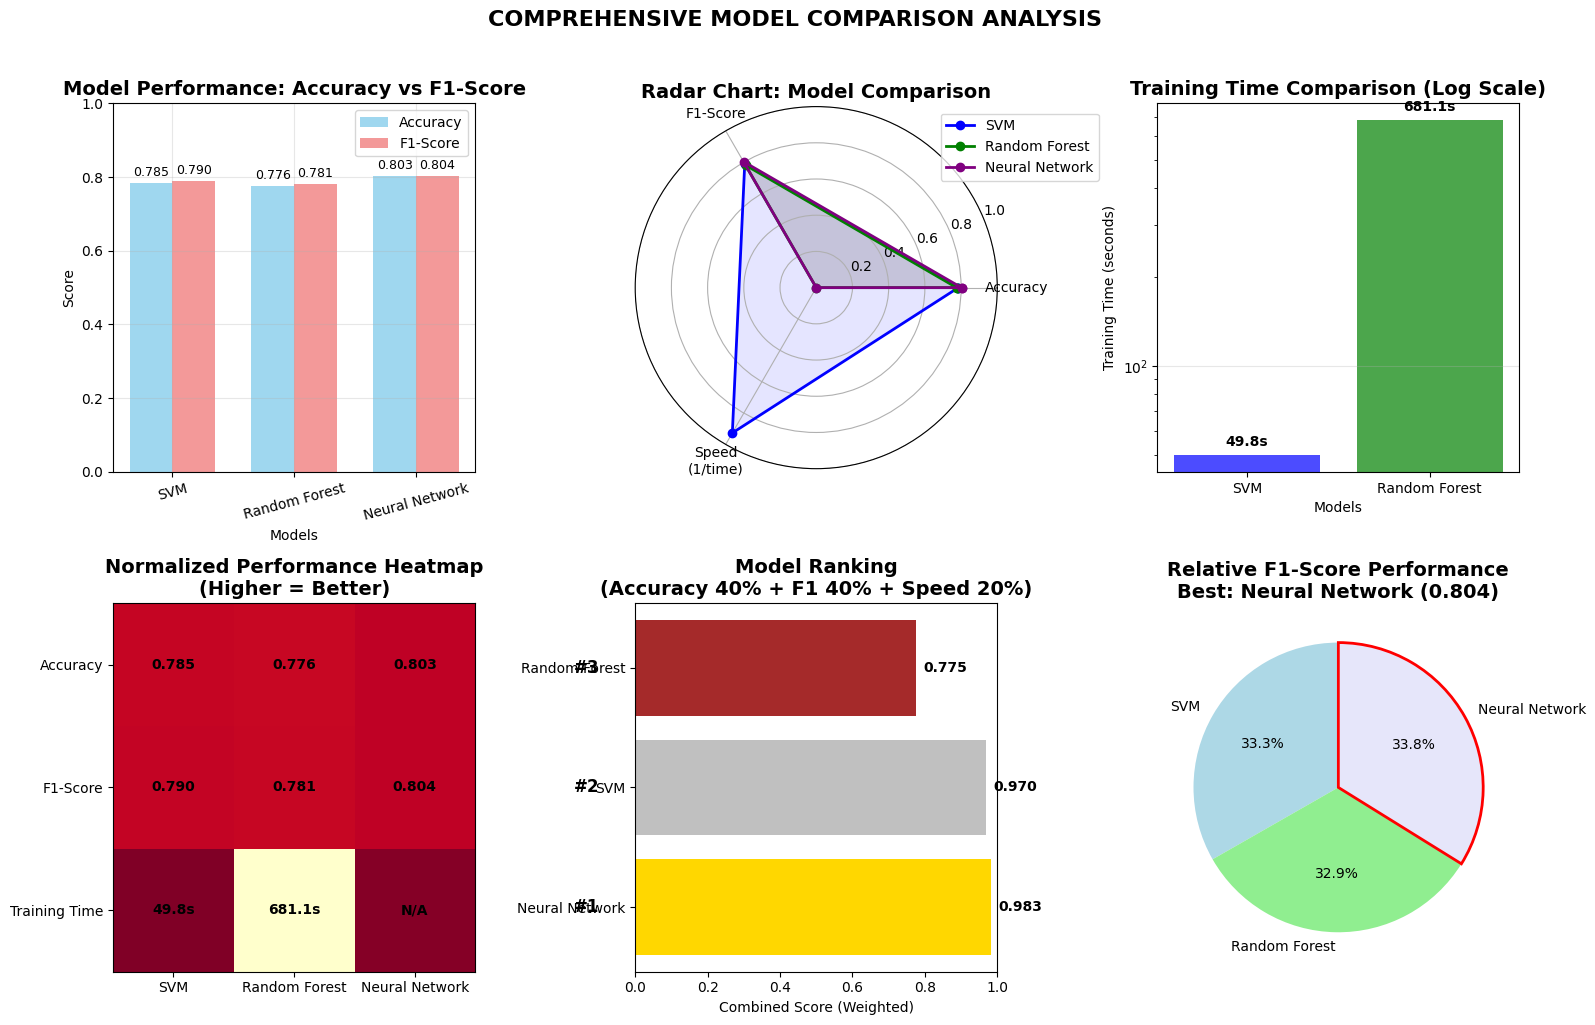


Summary Statistics:
Best Accuracy: 0.8025 (Neural Network)
Best F1-Score: 0.8036 (Neural Network)
Fastest Training: 49.75s (SVM)



In [38]:
# Cell 19: Visualization of Final Model Comparison
print("\n" + "="*60)
print("MODEL COMPARISON VISUALIZATION")
print("="*60)

# Prepare data for visualization
models = final_comparison['Model'].tolist()
accuracy = final_comparison['Accuracy'].tolist()
f1_scores = final_comparison['F1-Score'].tolist()

# For training time, handle the 'N/A' for Neural Network
training_times = []
for time_val in final_comparison['Training Time (s)']:
    if time_val == 'N/A':
        training_times.append(0)  # Placeholder for NN
    else:
        training_times.append(float(time_val))

# Create figure with subplots
fig = plt.figure(figsize=(16, 10))

# 1. Accuracy and F1-Score Comparison (Grouped Bar Chart)
ax1 = plt.subplot(2, 3, 1)
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, f1_scores, width, label='F1-Score', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance: Accuracy vs F1-Score', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15)
ax1.set_ylim([0, 1])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Radar Chart for Model Comparison
ax2 = plt.subplot(2, 3, 2, projection='polar')

# Metrics for radar chart
categories = ['Accuracy', 'F1-Score']
N = len(categories)

# Normalize training time for radar chart (inverse, since lower is better)
# We'll use a transformed value where higher is better
max_time = max(training_times[:2])  # Only consider SVM and RF for scaling
if max_time > 0:
    time_scores = [1 - (t/max_time) if t != 0 else 0 for t in training_times[:2]]
    time_scores.append(0)  # For NN
else:
    time_scores = [0, 0, 0]

# Create radar chart data
radar_metrics = ['Accuracy', 'F1-Score', 'Speed\n(1/time)']
N_radar = len(radar_metrics)

# Create angles for each axis
angles = [n / float(N_radar) * 2 * np.pi for n in range(N_radar)]
angles += angles[:1]  # Close the loop

# Plot each model
colors = ['blue', 'green', 'purple']
model_names = ['SVM', 'Random Forest', 'Neural Network']

for i, model in enumerate(model_names):
    if i < 2:  # SVM and RF have all metrics
        values = [accuracy[i], f1_scores[i], time_scores[i]]
    else:  # NN missing training time metric
        values = [accuracy[i], f1_scores[i], 0]

    values += values[:1]  # Close the loop
    ax2.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax2.fill(angles, values, alpha=0.1, color=colors[i])

# Set category labels
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(radar_metrics)
ax2.set_ylim([0, 1])
ax2.set_title('Radar Chart: Model Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 3. Training Time Comparison (Bar Chart - log scale)
ax3 = plt.subplot(2, 3, 3)
# Only show SVM and RF for training time
models_time = models[:2]
times = training_times[:2]

bars = ax3.bar(models_time, times, color=['blue', 'green'], alpha=0.7)
ax3.set_xlabel('Models')
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('Training Time Comparison (Log Scale)', fontsize=14, fontweight='bold')
ax3.set_yscale('log')  # Log scale due to large difference

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height * 1.05,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

ax3.grid(True, alpha=0.3, axis='y')

# 4. Performance Heatmap
ax4 = plt.subplot(2, 3, 4)

# Prepare data for heatmap
heatmap_data = pd.DataFrame({
    'SVM': [accuracy[0], f1_scores[0], training_times[0]],
    'Random Forest': [accuracy[1], f1_scores[1], training_times[1]],
    'Neural Network': [accuracy[2], f1_scores[2], 0]  # 0 placeholder for time
}, index=['Accuracy', 'F1-Score', 'Training Time'])

# For heatmap, we need to normalize training time differently
# Create a normalized version where lower time is better
norm_heatmap = heatmap_data.copy()
if max(training_times[:2]) > 0:
    norm_heatmap.loc['Training Time', :] = [1 - (t/max(training_times[:2])) if t != 0 else 0 for t in training_times]
else:
    norm_heatmap.loc['Training Time', :] = [0, 0, 0]

im = ax4.imshow(norm_heatmap, cmap='YlOrRd', aspect='auto')
ax4.set_xticks(np.arange(len(models)))
ax4.set_yticks(np.arange(len(norm_heatmap.index)))
ax4.set_xticklabels(models)
ax4.set_yticklabels(norm_heatmap.index)
ax4.set_title('Normalized Performance Heatmap\n(Higher = Better)', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(norm_heatmap.index)):
    for j in range(len(models)):
        if i < 2:  # For Accuracy and F1-Score
            text = f'{heatmap_data.iloc[i, j]:.3f}'
        else:  # For Training Time
            if j < 2:
                text = f'{heatmap_data.iloc[i, j]:.1f}s'
            else:
                text = 'N/A'

        ax4.text(j, i, text, ha='center', va='center', color='black', fontweight='bold')

# 5. Model Ranking Bar Chart
ax5 = plt.subplot(2, 3, 5)

# Calculate combined score (weighted average of normalized metrics)
# We'll weight Accuracy 40%, F1-Score 40%, Speed 20%
normalized_acc = [a/max(accuracy) for a in accuracy]
normalized_f1 = [f/max(f1_scores) for f in f1_scores]

# For speed, normalize inverse of time (higher time = lower score)
if max(training_times[:2]) > 0:
    normalized_speed = [1 - (t/max(training_times[:2])) if t != 0 else 0 for t in training_times]
else:
    normalized_speed = [0, 0, 0]

combined_scores = []
for i in range(len(models)):
    score = (0.4 * normalized_acc[i] + 0.4 * normalized_f1[i] + 0.2 * normalized_speed[i])
    combined_scores.append(score)

# Sort models by combined score
sorted_indices = np.argsort(combined_scores)[::-1]
sorted_models = [models[i] for i in sorted_indices]
sorted_scores = [combined_scores[i] for i in sorted_indices]

bars = ax5.barh(sorted_models, sorted_scores, color=['gold', 'silver', 'brown'])
ax5.set_xlabel('Combined Score (Weighted)')
ax5.set_title('Model Ranking\n(Accuracy 40% + F1 40% + Speed 20%)', fontsize=14, fontweight='bold')
ax5.set_xlim([0, 1])

# Add value labels
for i, (bar, score) in enumerate(zip(bars, sorted_scores)):
    width = bar.get_width()
    ax5.text(width + 0.02, bar.get_y() + bar.get_height()/2,
            f'{score:.3f}', ha='left', va='center', fontweight='bold')

    # Add rank labels
    ax5.text(-0.1, bar.get_y() + bar.get_height()/2,
            f'#{i+1}', ha='right', va='center', fontweight='bold', fontsize=12)

# 6. Pie Chart for Best Model Recommendation
ax6 = plt.subplot(2, 3, 6)

# Calculate percentage difference from best model
best_f1 = max(f1_scores)
f1_percentages = [score/best_f1 * 100 for score in f1_scores]

# Create pie chart
wedges, texts, autotexts = ax6.pie(f1_percentages, labels=models, autopct='%1.1f%%',
                                  colors=['lightblue', 'lightgreen', 'lavender'],
                                  startangle=90)

# Emphasize the best model
best_idx = f1_scores.index(best_f1)
wedges[best_idx].set_edgecolor('red')
wedges[best_idx].set_linewidth(2)

ax6.set_title(f'Relative F1-Score Performance\nBest: {models[best_idx]} ({best_f1:.3f})',
              fontsize=14, fontweight='bold')

plt.suptitle('COMPREHENSIVE MODEL COMPARISON ANALYSIS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("="*40)
print(f"Best Accuracy: {max(accuracy):.4f} ({models[accuracy.index(max(accuracy))]})")
print(f"Best F1-Score: {max(f1_scores):.4f} ({models[f1_scores.index(max(f1_scores))]})")
print(f"Fastest Training: {min(training_times[:2]):.2f}s ({models[:2][training_times[:2].index(min(training_times[:2]))]})")
print("\n" + "="*60)